In [229]:
import pandas as pd
import Utils
import pulp
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [230]:
model_a_optimal = pd.read_csv('model_a_optimal_transfers.csv')
model_a_cheapest = pd.read_csv('model_a_cheapest_transfers.csv')
model_b_optimal = pd.read_csv('model_b_optimal_transfers.csv')
model_b_cheapest = pd.read_csv('model_b_optimal_transfers.csv')

In [231]:
gw_preds = pd.read_csv('all_predictions.csv')
hist_df = pd.read_csv('all_with_history.csv')

C:\Users\Tasha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [232]:
fixture_difficulty = {'Liverpool':5, 'Manchester City': 5, 'Manchester United': 5, 'Chelsea':5,'Leicester City':4,
                     'Tottenham': 4,'Tottenham Hotspur': 4, 'Arsenal': 4, 'Everton':4, 'Wolverhampton Wanderers':3, 'Leeds':2,
                      'Southampton':2, 'West Ham United': 3, 'Aston Villa': 2,  'Watford':1, 'Crystal Palace': 3,
                      'Norwich': 1, 'Burnley': 1, 'Brentford':2,'Brighton and Hove Albion':2, 'Newcastle United': 1}

In [233]:
%store -r teams1
%store -r teams2
%store -r teams3
%store -r teams4

# Triple Captain

In [234]:
def pick_captain(model_df, fixture_difficulty_dict, all_gws):
    #get fixture difficulty ranking differential
    all_gws['teamdiff'] = all_gws.player_team_name.map(fixture_difficulty_dict)
    all_gws['oppdiff'] = all_gws.opponent_team_name.map(fixture_difficulty_dict)
    all_gws['fdr_diff'] = all_gws.teamdiff-all_gws.oppdiff
    fdd = []
    
    #compare it the captains we selected
    for i, r in model_df.iterrows():
        df  = all_gws[(all_gws.season_num== 5) & (all_gws.full_name == r.captain) & (all_gws.GW == r.GW)]
        diff = df.fdr_diff.sum()/len(df)
        fdd.append(diff)
    


    for i,j,k,l in zip(list(model_df.captain), fdd, list(model_df.GW), list(model_df.captain_points)):
        if j == 4:
            break
    
    return i, k, l

# Bench Boost

In [235]:
def pick_bench_week(threshold, bench, gw_preds):
    
    bench_df = gw_preds[(gw_preds.full_name.isin(bench)) & (gw_preds. season_num == 5)].groupby('GW').sum()['predicted']
    
    for i in range(len(bench_df)):
        if bench_df.iloc[i]/4 >= threshold:
                   break
        
    return bench_df.index[i]       

# Free Hit and Wildcard

In [236]:
#still dont know why this doesn't work properly if imported from utils
def linear_prog(df, max_budget = 1000, gk_constraint = 2, def_constraint = 5, fwd_constraint = 3,
                mid_constraint = 5):
    
    #define the sets
    pos = df.position.unique()
    teams = df.player_team_name.unique()
    
    #define the constraints
    pos_constraint = {'GK': gk_constraint, 'DEF': def_constraint, 'MID': mid_constraint, 'FWD': fwd_constraint}
    
    #set up decision variables
    positions, clubs, names, values,  points, decision_vars = [], [], [], [], [], []
    for i in df.index:
        positions.append(df.position[i])
        clubs.append(df.player_team_name[i])
        names.append(df.full_name[i])
        values.append(df.value[i])
        points.append(df.predicted[i])
        decision_vars.append(pulp.LpVariable("x_" + str(i), cat = 'Binary')) #this makes variables like x_1, x_2 for the players
      
    #define the objective function
    prob = pulp.LpProblem("Initialisation", pulp.LpMaximize) #maximisation problem
    prob += pulp.lpSum(decision_vars[i] * points[i] for i in range(len(df))) #objective to maximise
    
    #set the constraints/add them to the problem
    prob += pulp.lpSum(decision_vars[i] * df.value[df.index[i]] for i in range(len(df))) <= max_budget
    prob += pulp.lpSum(decision_vars[i] for i in range(len(df))) == 15
    
    for p in pos:
      prob += pulp.lpSum(decision_vars[i] for i in range(len(df)) if positions[i] == p) <= pos_constraint[p]

    for t in teams:
      prob += pulp.lpSum(decision_vars[i] for i in range(len(df)) if clubs[i] == t) <= 3 

    #solve problem
    prob.solve()
    
    return prob

In [237]:
def freehit_team(gw, mode, money_available, all_gw_preds, cheapest_bench = None):
    free_gw = all_gw_preds[all_gw_preds.GW == gw]
    
    if mode == 'optimal':
        pr = linear_prog(free_gw, money_available)
        fh = Utils.construct_best_team(free_gw, pr)
        
    elif mode == 'cheapest':
        pr = Utils.linear_prog_with_bench(cheapest_bench, free_gw, money_available,
                                          gk_constraint = 1, def_constraint = 4, fwd_constraint = 2, 
                                          mid_constraint = 4)
        fh = Utils.construct_best_team(free_gw, pr)
        
    
    return fh

In [238]:
#had to change to include money banked feature
def transfer_algorithm(overall, initial_team, money_banked, team_and_bench, gw_start = 2, gw_end = 39):
    team_list = [[0],[0],[0],[0],[0],list(initial_team.Name)]
    gw_list = np.arange(gw_start,gw_end)
    team_dict = Counter([i for i in team_and_bench.Team])
    money_banked = money_banked 
    #in our case this will always be 0 as we used the full 1000,
    #but it is good to set the algorithm up to handle any team
    
    purchase_dict = {}

    for i in team_and_bench.Name:
        purchase_dict[i] = 1
     
    options_in, options_out = [], []
    
    for gw in gw_list:
        player_out = Utils.get_player_out(overall, team_list[gw-2], gw)
        cost_player_out = Utils.get_available_cost(player_out, overall, gw, purchase_dict[player_out])
        
        money_banked = money_banked + cost_player_out
        print(player_out,money_banked)
        team_sheet = list(team_list[gw-2])
        player_in,  player_in_cost,  team_dict, purchase_dict = Utils.get_best_predicted_swap(player_out, overall, gw, money_banked, team_dict, purchase_dict, team_sheet)
        money_banked = money_banked - player_in_cost
        print(player_in, money_banked)
        new_team = Utils.get_team_sheet(team_list[gw-2], player_out, player_in)
        team_list.append(list(new_team))
        options_in.append(player_in)
        options_out.append(player_out)
#         if gw == 5:
#             print(money_banked)
        
    return options_in, options_out, team_list

In [239]:
#change to incorporate start week
def calc_captain_and_points(x15, teamlist, original_data, overall, benchdict,start):
    gw_points = {}
    captain_decisions = {}
    captain_pnts = {}

    for i in np.arange(start,39): #from gw 1 to 38
        if i == start: #gw 1 is special case
            df = x15
            old, subbed_team = Utils.make_subs(df, original_data,start, benchdict) #get new team list and make the neccessary subs
            gw_points[i] = overall[overall.full_name.isin(subbed_team) & (overall.GW == start)]['total_points'].sum() #calc points after subs
            #calculate best predicted performer and make them captain
            captain = [i for i in overall[overall.full_name.isin(subbed_team) & (overall.GW == start)].sort_values('predicted').tail(1)['full_name']][0]
            captain_points = overall[(overall.full_name == captain) & (overall.GW == start)]['total_points'].sum()
            captain_decisions[captain] = captain
            captain_pnts[i] = captain_points
        else:
            #get from updated team list
            df = overall[overall.full_name.isin(teamlist[i-2]) & (overall.GW == i)][['full_name', 'player_team_name','position',
                                                                             'value','predicted','actual']]
            df = df.rename(columns = {'full_name': 'Name', 'player_team_name': 'Team', 'position': 'Position', 'value': 'Value',
                          'predicted': 'Predicted Points', 'actual': 'Actual Points'})
        
            old, subbed_team = Utils.make_subs(df, original_data, i, benchdict)
            gw_points[i] = overall[overall.full_name.isin(subbed_team) & (overall.GW == i)]['total_points'].sum()    
            #get historical overachievement
            captain = [i for i in overall[overall.full_name.isin(subbed_team) & (overall.GW == i-1)].sort_values('avg_error').tail(1)['full_name']][0]
            captain_points = overall[(overall.full_name == captain) & (overall.GW == i)]['total_points'].sum()
            captain_decisions[i] = captain
            captain_pnts[i] = captain_points
            
    return gw_points, captain_decisions, captain_pnts

In [240]:
def wildcard(bench_dict, bench_list, preds, history, init_df, start,money_banked):
    
    transfer_df = Utils.get_rolling_points_avg(preds)
    
    x11 = transfer_df[(transfer_df.full_name.isin(init_df.Name)) & (~transfer_df.full_name.isin(bench_list)) \
                      & (transfer_df.GW == start)]
    
    x11 = x11.rename(columns = {'full_name': 'Name', 'player_team_name': 'Team', 'position': 'Position', 'value': 'Value',
                          'predicted': 'Predicted Points', 'actual': 'Actual Points'})
    
    
    
    benched_df = transfer_df[(transfer_df.full_name.isin(bench_list)) & (transfer_df.GW == 6)]
    benched_df = benched_df.rename(columns = {'full_name': 'Name', 'player_team_name': 'Team', 'position': 'Position', 'value': 'Value',
                          'predicted': 'Predicted Points', 'actual': 'Actual Points'})
    
    x15 = pd.concat([x11,benched_df])
    
    players_in, players_out, teams = transfer_algorithm(transfer_df, x11, money_banked, x15, gw_start = start+1,gw_end = 39)
    wc_trans_opt = Utils.create_output_table(transfer_df, players_in, players_out, teams, gw_start = start+1, gw_end = 39)
    
    gw_points, captain_decisions, captain_pnts =calc_captain_and_points(x15, teams, history, transfer_df, bench_dict,start)
    
    wc_trans_opt['points'] = gw_points.values()
    wc_trans_opt['captain'] = captain_decisions.values()
    wc_trans_opt['captain_points'] = captain_pnts.values()
    wc_trans_opt['total_points'] = wc_trans_opt.points + wc_trans_opt.captain_points
    
    return wc_trans_opt, teams

## Model A: Optimised

The first game chip was bench boost in gw3: but not if a wildcard decision was going to be made before this, then we would have to run the bench boost program after it was used as the bench would have changed. Next was gw6 which was the wildcard. Originally we had wanted to use the triple captain in week 8, but then needed to update the rest of the df after gw6 for the wildcard so this changed. The triple captain was used in week 17 instead. Then we have freehit (gw18), wildcard(gw26), freehit (gw30).

In [241]:
bench_a_opt = ['alex_mccarthy', 'ezri_konsa_ngoyo', 'yves_bissouma','dominic_calvert_lewin'] #this was the initial bench

In [242]:
bench_gw = pick_bench_week(3,bench_a_opt, gw_preds)
bench_gw

3

In [243]:
benchactuals = gw_preds[(gw_preds.full_name.isin(bench_a_opt)) & (gw_preds.GW == bench_gw) ].total_points.sum()
benchactuals

13

### Wild Card 1: GW6

In [244]:
#if you want to check TransferAlgorithm.ipynb, we got the 58 from there as this was the money banked in gw5
hist_df[(hist_df.full_name.isin(teams1[4])) & (hist_df.GW == 5) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(bench_a_opt)) & (hist_df.GW == 5) & (hist_df.season_num == 5)].value.sum() + 58

1013

In [245]:
wc1_a_opt = freehit_team(6, 'optimal', 1013, gw_preds)

In [246]:
wc1_a_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
7,aaron_wan_bissaka,Manchester United,DEF,54,3.312695,2
12,antonio_rüdiger,Chelsea,DEF,56,3.393032,1
3,luke_shaw,Manchester United,DEF,55,3.521674,0
6,alex_mccarthy,Southampton,GK,45,3.588416,2
9,illan_meslier,Leeds,GK,50,3.627592,1
11,virgil_van_dijk,Liverpool,DEF,66,3.637393,1
2,marcos_alonso,Chelsea,DEF,58,3.846535,1
5,james_ward_prowse,Southampton,MID,64,3.873319,2
4,allan_saint_maximin,Newcastle United,FWD,67,4.077878,8
1,ilkay_gündogan,Manchester City,MID,73,4.196299,0


In [247]:
new_bench_a_opt = {'DEF':'aaron_wan_bissaka', 'GK':'alex_mccarthy','MID':'james_ward_prowse','FWD':'allan_saint_maximin'}
bench_opt_list = ['aaron_wan_bissaka','alex_mccarthy','james_ward_prowse','allan_saint_maximin']

In [248]:
wc1_trans_opt, teams1 = wildcard(new_bench_a_opt, bench_opt_list, gw_preds, hist_df, wc1_a_opt,6,58)

illan_meslier 108
aaron_ramsdale 63
patrick_bamford 141
hee_chan_hwang 85
jack_grealish 164
mohamed_salah 36
luke_shaw 89
reece_james 33
ilkay_gündogan 105
conor_gallagher 48
heung_min_son 149
maxwel_cornet 88
jamie_vardy 194
emmanuel_dennis 141
ismaila_sarr 201
diogo_jota 123
marcos_alonso 178
joão_pedro_cavaco_cancelo 110
hee_chan_hwang 166
joshua_king 108
joshua_king 166
armando_broja 115
armando_broja 166
hee_chan_hwang 110
hee_chan_hwang 166
armando_broja 114
armando_broja 166
odsonne_edouard 103
virgil_van_dijk 168
trent_alexander_arnold 85
antonio_rüdiger 143
toti_antónio_gomes 98
odsonne_edouard 161
wout_weghorst 96
wout_weghorst 161
armando_broja 109
toti_antónio_gomes 154
kieran_trippier 104
maxwel_cornet 163
philippe_coutinho_correia 90
armando_broja 143
wout_weghorst 78
wout_weghorst 143
armando_broja 88
armando_broja 143
odsonne_edouard 80
odsonne_edouard 143
hee_chan_hwang 89
hee_chan_hwang 143
armando_broja 88
armando_broja 143
teemu_pukki 84
teemu_pukki 143
armando_broj

In [249]:
wc1_trans_opt

,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,6,None,None,0,0,42,jamie_vardy,11,53
1,7,aaron_ramsdale,illan_meslier,6,6,34,marcos_alonso,0,34
2,8,hee_chan_hwang,patrick_bamford,0,2,31,hee_chan_hwang,2,33
3,9,mohamed_salah,jack_grealish,6,24,66,mohamed_salah,24,90
4,10,reece_james,luke_shaw,5,21,52,mohamed_salah,5,57
5,11,conor_gallagher,ilkay_gündogan,3,11,44,mohamed_salah,5,49
6,12,maxwel_cornet,heung_min_son,2,7,72,mohamed_salah,8,80
7,13,emmanuel_dennis,jamie_vardy,12,10,49,mohamed_salah,6,55
8,14,diogo_jota,ismaila_sarr,0,8,46,mohamed_salah,15,61
9,15,joão_pedro_cavaco_cancelo,marcos_alonso,1,2,28,mohamed_salah,6,34


### Captain Choice

This was also checked before the wild-card. We know there is no bonus chip from now until gw18, so it is fine to use one in gw17.

In [250]:
fixture_difficulty = {'Liverpool':5, 'Manchester City': 5, 'Manchester United': 5, 'Chelsea':5,'Leicester City':4,
                     'Tottenham': 4,'Tottenham Hotspur': 4, 'Arsenal': 4, 'Everton':4, 'Wolverhampton Wanderers':3, 'Leeds':2,
                      'Southampton':2, 'West Ham United': 3, 'Aston Villa': 2,  'Watford':1, 'Crystal Palace': 3,
                      'Norwich': 1, 'Burnley': 1, 'Brentford':2,'Brighton and Hove Albion':2, 'Newcastle United': 1}

In [251]:
model_a_opt_cap = pick_captain(wc1_trans_opt, fixture_difficulty, hist_df)

In [252]:
model_a_opt_cap # week 17

('mohamed_salah', 17, 8)

### Free Hit 1: WK18

In [253]:
teams1[16]

['conor_gallagher',
 'reece_james',
 'virgil_van_dijk',
 'antonio_rüdiger',
 'diogo_jota',
 'hee_chan_hwang',
 'emmanuel_dennis',
 'joão_pedro_cavaco_cancelo',
 'mohamed_salah',
 'aaron_ramsdale',
 'maxwel_cornet']

In [254]:
#17 was a blank, so check week before
hist_df[(hist_df.full_name.isin(teams1[16])) & (hist_df.GW == 16) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(bench_opt_list)) & (hist_df.GW == 16) & (hist_df.season_num == 5)].value.sum() + 115

#remember to add the new bench
#the 115 million comes from the money in the bank printout in the transfer algorithm from week 17.
#didnt have time to go back and edit/link it to this script, but feel free to inspect TransferAlgorithm.ipynb for clarification

1096

In [255]:
fh1_a_opt = freehit_team(18, 'optimal', 1096, gw_preds)
fh1_a_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
4,max_kilman,Wolverhampton Wanderers,DEF,45,3.022496,6
3,romain_saïss,Wolverhampton Wanderers,DEF,50,3.195237,7
10,reece_james,Chelsea,DEF,63,3.497172,6
7,illan_meslier,Leeds,GK,49,3.563218,3
0,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,51,3.629320,6
1,allan_saint_maximin,Newcastle United,FWD,67,3.753819,1
13,alexandre_lacazette,Arsenal,FWD,84,3.834175,5
12,andrew_robertson,Liverpool,DEF,71,3.843978,9
14,raphael_dias_belloli,Leeds,MID,66,3.967209,7
6,jack_grealish,Manchester City,MID,76,4.324362,0


This is only temporary, so we can just do this manually: the bench is: max_kilman (6), meslier(3), saint maximin (1), belloli (7) but we see that foden and grealish didn't play, so we get saint maximin and belloli in according to the transfer order logic. (+7,+1) and captain kane +6

In [256]:
fh1_a_opt['Actual Points'].sum()+7+1-6-3+6

87

### Freehit 2: GW30

In [257]:
hist_df[(hist_df.full_name.isin(teams1[28])) & (hist_df.GW == 28) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()\
+hist_df[(hist_df.full_name.isin(bench_opt_list)) & (hist_df.GW == 28) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()+80

1094.0

In [258]:
fh2_a_opt = freehit_team(30, 'optimal', 1114, gw_preds)
fh2_a_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
14,çaglar_söyüncü,Leicester City,DEF,49,2.882742,2
4,conor_coady,Wolverhampton Wanderers,DEF,49,3.031443,1
2,romain_saïss,Wolverhampton Wanderers,DEF,51,3.113343,1
8,tyrone_mings,Aston Villa,DEF,50,3.156121,1
1,matthew_cash,Aston Villa,DEF,52,3.330743,2
0,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,53,3.717529,1
10,bukayo_saka,Arsenal,MID,67,3.771102,11
3,ivan_toney,Brentford,FWD,66,3.806624,2
13,emiliano_martínez,Aston Villa,GK,55,3.820688,3
12,raphael_dias_belloli,Leeds,MID,65,3.950763,0


In [259]:
fh2_a_opt['Actual Points'].sum()-2-1-11+13

60

### Wildcard 2: GW 36

In [260]:
hist_df[(hist_df.full_name.isin(teams1[34])) & (hist_df.GW == 34) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()\
+hist_df[(hist_df.full_name.isin(bench_opt_list)) & (hist_df.GW == 34) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()+87

1096.0

In [261]:
wc2_a_opt = freehit_team(36, 'optimal', 1095, gw_preds)

In [262]:
wc2_a_opt.sort_values('Predicted Points') #dont know why but this doesnt pick up the double fixtures, they actually scored more

,Name,Team,Position,Value,Predicted Points,Actual Points
3,illan_meslier,Leeds,GK,48,3.664561,1
11,joão_pedro_cavaco_cancelo,Manchester City,DEF,72,3.733154,5
1,marcos_alonso,Chelsea,DEF,57,3.776332,1
13,emiliano_martínez,Aston Villa,GK,55,3.810089,2
6,christian_eriksen,Brentford,MID,56,3.854209,6
12,virgil_van_dijk,Liverpool,DEF,68,3.926811,2
9,bukayo_saka,Arsenal,MID,67,3.988816,2
10,joão_pedro_cavaco_cancelo,Manchester City,DEF,72,4.088281,9
7,andrew_robertson,Liverpool,DEF,73,4.132455,2
14,ollie_watkins,Aston Villa,FWD,75,4.201796,2


In [263]:
new_bench_a_opt = {'DEF':'joão_pedro_cavaco_cancelo', 'GK':'illan_meslier','MID':'christian_eriksen','FWD':'ollie_watkins'}
bench_opt_list = ['joão_pedro_cavaco_cancelo','illan_meslier','christian_eriksen','ollie_watkins']

In [275]:
wc2_trans_opt, teams2 = wildcard(new_bench_a_opt, bench_opt_list, gw_preds, hist_df, wc2_a_opt,36,87)

harry_kane 211
emmanuel_dennis 152
emiliano_martínez 207
alisson_ramses_becker 146


In [276]:
wc2_trans_opt

,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,36,None,None,0,0,76,harry_kane,15,91
1,37,emmanuel_dennis,harry_kane,7,0,37,heung_min_son,3,40
2,38,alisson_ramses_becker,emiliano_martínez,0,3,36,heung_min_son,12,48


In [274]:
#really bad but didnt have time to fix
#reran this when doing gw36

#change the zeros to no. game weeks - 1 if the algorithm stops working i.e. gw 19, need 18 zeros

def transfer_algorithm(overall, initial_team, money_banked, team_and_bench, gw_start = 2, gw_end = 39):
    team_list = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],
                 [0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0], [0],
                 [0],[0],[0],[0],[0],[0],[0],list(initial_team.Name)] #i dont know a better way
    gw_list = np.arange(gw_start,gw_end)
    team_dict = Counter([i for i in team_and_bench.Team])
    money_banked = money_banked 
    #in our case this will always be 0 as we used the full 1000,
    #but it is good to set the algorithm up to handle any team
    
    purchase_dict = {}

    for i in team_and_bench.Name:
        purchase_dict[i] = 1
     
    options_in, options_out = [], []
    
    for gw in gw_list:
        player_out = Utils.get_player_out(overall, team_list[gw-2], gw)
        cost_player_out =  Utils.get_available_cost(player_out, overall, gw, purchase_dict[player_out])
        #a bit buggy, change to transfer cost yourself if not working
        
        money_banked = money_banked + cost_player_out
        print(player_out,money_banked)
        team_sheet = list(team_list[gw-2])
        player_in,  player_in_cost,  team_dict, purchase_dict = Utils.get_best_predicted_swap(player_out, overall, gw, money_banked, team_dict, purchase_dict, team_sheet)
        money_banked = money_banked - player_in_cost
        print(player_in, money_banked)
        new_team = Utils.get_team_sheet(team_list[gw-2], player_out, player_in)
        team_list.append(list(new_team))
        options_in.append(player_in)
        options_out.append(player_out)
#         if gw == 5:
#             print(money_banked)
        
    return options_in, options_out, team_list

#[0],[0],
                 #[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]

# Combine it all

In [282]:
model_a_opt_bc = pd.concat([model_a_optimal[:5], wc1_trans_opt[:30],wc2_trans_opt ])

In [283]:
model_a_opt_bc #ignore last col, not needed

,Unnamed: 0,GW,transferred_in,transferred_out,out_points,in_points,captain,captain_points,total_points,points
0,0.0,1,None,None,0,None,bruno_miguel_borges_fernandes,20,78,NaN
1,1.0,2,michail_antonio,harry_kane,0,16,bruno_miguel_borges_fernandes,1,61,NaN
2,2.0,3,raphaël_varane,michael_keane,6,12,michail_antonio,11,70,NaN
3,3.0,4,conor_gallagher,rúben_diogo_da_silva_neves,3,8,michail_antonio,-1,35,NaN
4,4.0,5,odsonne_edouard,patrick_bamford,5,1,odsonne_edouard,1,25,NaN
0,NaN,6,None,None,0,0,jamie_vardy,11,53,42.0
1,NaN,7,aaron_ramsdale,illan_meslier,6,6,marcos_alonso,0,34,34.0
2,NaN,8,hee_chan_hwang,patrick_bamford,0,2,hee_chan_hwang,2,33,31.0
3,NaN,9,mohamed_salah,jack_grealish,6,24,mohamed_salah,24,90,66.0
4,NaN,10,reece_james,luke_shaw,5,21,mohamed_salah,5,57,52.0


In [280]:
overall_wildcard_only = model_a_opt_bc.total_points.sum()
triple_cap = 8 #see earlier
benchboost = 13 #see earlier
freehitgw18 = 87-43 #it is only the difference that we add
freehitgw30 = 60-5

final_total_mod_a_opt = overall_wildcard_only + triple_cap+benchboost+freehitgw18+freehitgw30

In [281]:
final_total_mod_a_opt

2029

Your ranking is:  2516846.939601902
You are in the top:  27.96496599557669 %


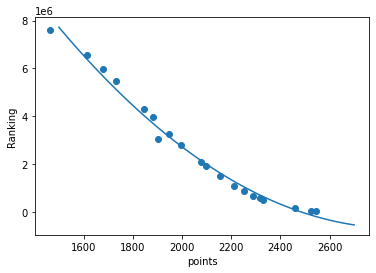

In [284]:
#this is just from searching through friends and top rankings on fpl website
#discrepency along the line is because when people draw they are all given same ranking
overallpnts =[1949, 1614, 1902, 2098, 2213, 2077, 2545, 2330, 2154, 2290 , 2319, 2253, 2523, 1881, 1679, 2461,1463,
              1733, 1847,1996]
ranking = [3282321, 6573368, 3058531, 1941652, 1116673, 2112453, 54140, 534847, 1508675, 704813, 580744,
           886715, 77022, 3965302, 5998772, 170565, 7621055, 5485941,4319545,2827589]
from sklearn.linear_model import LinearRegression
import numpy

mymodel = numpy.poly1d(numpy.polyfit(overallpnts, ranking, 2)) #fit a polynomial
myline = numpy.linspace(1500, 2700, 100)

plt.scatter(overallpnts, ranking)
plt.plot(myline, mymodel(myline))
plt.xlabel('points')
plt.ylabel('Ranking')
pred = mymodel(2029)
print("Your ranking is: ", pred)
print("You are in the top: ", pred/9000000*100,"%") #there were over 9 million players in gw 1. 

## Model A: Cheapest Bench

This time, the triple captain was actually chosen before the first Wildcard. Then like before the first WC was used in gw6, free hit in gw18 and so on

### Triple Captain WK1

In [191]:
model_a_cheap_cap = pick_captain(model_a_cheapest, fixture_difficulty, hist_df)

In [192]:
model_a_cheap_cap

('mohamed_salah', 1, 17)

In [193]:
model_a_cheapest

,Unnamed: 0,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,0,1,None,None,0,None,59,mohamed_salah,17,76
1,1,2,michail_antonio,harry_kane,0,16,66,bruno_miguel_borges_fernandes,1,67
2,2,3,raphaël_varane,michael_keane,6,12,56,michail_antonio,11,67
3,3,4,conor_gallagher,stuart_dallas,2,8,45,michail_antonio,-1,44
4,4,5,odsonne_edouard,patrick_bamford,5,1,37,odsonne_edouard,1,38
5,5,6,saïd_benrahma,jack_grealish,3,3,38,odsonne_edouard,2,40
6,6,7,takehiro_tomiyasu,james_tarkowski,5,6,45,michail_antonio,2,47
7,7,8,andros_townsend,bruno_miguel_borges_fernandes,5,2,40,mohamed_salah,13,53
8,8,9,edouard_mendy,vicente_guaita,2,6,48,mohamed_salah,24,72
9,9,10,reece_james,raphaël_varane,6,21,63,mohamed_salah,5,68


### Wild Card WK6

In [194]:
bench_a_ch = ['ellery_balcombe','charlie_goode','yves_bissouma','stipe_perica']

In [203]:
bench_gw_ch = pick_bench_week(2,bench_a_ch, gw_preds) #thresh of 1 was predicting gw1, we already used triple cap so cant
bench_gw_ch #we will have to re-run this after we use other chips

38

In [225]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 6)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 6)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 6)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 6)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

In [226]:
cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])
cheapest

,full_name,player_team_name,position,value,predicted,actual
13192,ben_foster,Watford,GK,40,2.606980,3
19691,andrew_omobamidele,Norwich,DEF,39,0.557998,0
11332,fabian_delph,Everton,MID,44,0.241843,0
5252,dane_scarlett,Tottenham Hotspur,FWD,45,0.090037,0


In [227]:
#if you want to check TransferAlgorithm.ipynb, we got the 58 from there as this was the money banked in gw5
hist_df[(hist_df.full_name.isin(teams2[4])) & (hist_df.GW == 5) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 5) & (hist_df.season_num == 5)].value.sum() + 58

985

In [258]:
985-cheapest.value.sum()

817

In [259]:
wc1_a_ch = freehit_team(6, 'cheapest', 817, gw_preds, cheapest)

In [260]:
wc1_a_ch.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
4,aaron_wan_bissaka,Manchester United,DEF,54,3.312695,2
6,rúben_santos_gato_alves_dias,Manchester City,DEF,61,3.483147,5
2,luke_shaw,Manchester United,DEF,55,3.521674,0
3,alex_mccarthy,Southampton,GK,45,3.588416,2
1,marcos_alonso,Chelsea,DEF,58,3.846535,1
9,ismaila_sarr,Watford,MID,62,4.240517,9
5,jack_grealish,Manchester City,MID,80,4.475283,3
10,patrick_bamford,Leeds,FWD,79,4.656163,0
8,heung_min_son,Tottenham Hotspur,MID,100,5.133696,7
0,jamie_vardy,Leicester City,FWD,104,5.433883,11


In [261]:
bench_dict_cheap = {'FWD': 'dane_scarlett','MID': 'fabian_delph','DEF':'andrew_omobamidele', 'GK': 'ben_foster'}

In [262]:
wc1_trans_ch, teams2 = wildcard(bench_dict_cheap, list(cheapest.full_name), gw_preds, hist_df, wc1_a_ch,6,58)

patrick_bamford 137
hee_chan_hwang 82
jack_grealish 162
mohamed_salah 35
aaron_wan_bissaka 89
trevoh_chalobah 41
luke_shaw 94
reece_james 38
bruno_miguel_borges_fernandes 155
conor_gallagher 98
heung_min_son 199
maxwel_cornet 138
jamie_vardy 244
emmanuel_dennis 191
alex_mccarthy 236
aaron_ramsdale 187
ismaila_sarr 246
bernardo_mota_veiga_de_carvalho_e_silva 172
marcos_alonso 228
trent_alexander_arnold 147
hee_chan_hwang 202
armando_broja 151
rúben_santos_gato_alves_dias 211
joão_pedro_cavaco_cancelo 143
trevoh_chalobah 190
gabriel_magalhães 137
armando_broja 188
odsonne_edouard 125
odsonne_edouard 188
armando_broja 135
bernardo_mota_veiga_de_carvalho_e_silva 209
philippe_coutinho_correia 139
armando_broja 192
wout_weghorst 127
wout_weghorst 192
armando_broja 140
maxwel_cornet 199
jarrod_bowen 129
armando_broja 181
wout_weghorst 116
reece_james 175
kieran_trippier 125
wout_weghorst 190
armando_broja 135
armando_broja 190
odsonne_edouard 127
odsonne_edouard 190
hee_chan_hwang 136
hee_cha

In [263]:
wc1_trans_ch

,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,6,None,None,0,0,40,bruno_miguel_borges_fernandes,0,40
1,7,hee_chan_hwang,patrick_bamford,0,13,46,ismaila_sarr,1,47
2,8,mohamed_salah,jack_grealish,0,13,44,mohamed_salah,13,57
3,9,trevoh_chalobah,aaron_wan_bissaka,-1,6,47,mohamed_salah,24,71
4,10,reece_james,luke_shaw,5,21,48,mohamed_salah,5,53
5,11,conor_gallagher,bruno_miguel_borges_fernandes,2,11,47,mohamed_salah,5,52
6,12,maxwel_cornet,heung_min_son,2,7,48,mohamed_salah,8,56
7,13,emmanuel_dennis,jamie_vardy,12,10,27,mohamed_salah,6,33
8,14,aaron_ramsdale,alex_mccarthy,2,3,43,mohamed_salah,15,58
9,15,bernardo_mota_veiga_de_carvalho_e_silva,ismaila_sarr,0,15,33,mohamed_salah,6,39


### Bench Boost GW 10

In [264]:
bench_gw_ch = pick_bench_week(0.9,list(cheapest.full_name), gw_preds) #now see if bench any better
bench_gw_ch
#1 said gw 36 and we know we will be using bench boost then, so gw 10 was next best

10

In [265]:
gw_preds[(gw_preds.full_name.isin(cheapest.full_name)) & (gw_preds.GW == 10)].total_points.sum() #lucky

13

### Free Hit GW 18

In [291]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])
cheapest

,full_name,player_team_name,position,value,predicted,actual
22609,scott_carson,Manchester City,GK,39,0.078327,0
4729,konstantinos_tsimikas,Liverpool,DEF,38,0.265846,0
13698,jamie_shackleton,Leeds,MID,44,1.201675,0
5454,sam_greenwood,Leeds,FWD,45,0.077740,1


In [292]:
hist_df[(hist_df.full_name.isin(teams2[16])) & (hist_df.GW == 16) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()\
+hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 16) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()+151

1061.0

In [293]:
1061-cheapest.value.sum()

895

In [294]:
fh1_a_ch = freehit_team(18, 'cheapest', 895, gw_preds, cheapest)
fh1_a_ch.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
2,romain_saïss,Wolverhampton Wanderers,DEF,50,3.195237,7
7,reece_james,Chelsea,DEF,63,3.497172,6
4,hugo_lloris,Tottenham Hotspur,GK,54,3.636211,2
0,allan_saint_maximin,Newcastle United,FWD,67,3.753819,1
8,andrew_robertson,Liverpool,DEF,71,3.843978,9
9,mason_mount,Chelsea,MID,77,4.170639,3
3,trent_alexander_arnold,Liverpool,DEF,82,4.343480,7
1,riyad_mahrez,Manchester City,MID,86,4.450593,12
10,kevin_de_bruyne,Manchester City,MID,118,4.846832,3
5,heung_min_son,Tottenham Hotspur,MID,103,5.065667,7


In [295]:
fh1_a_ch['Actual Points'].sum() + 6 + 1

70

In [296]:
gw_preds[(gw_preds.full_name.isin(cheapest.full_name)) & (gw_preds.GW == 18)]['total_points'] #^^ add to above

4729     0
5454     1
13698    0
22609    0
Name: total_points, dtype: int64

### Freehit GW30

In [297]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])
cheapest

,full_name,player_team_name,position,value,predicted,actual
16180,patrik_gunnarsson,Brentford,GK,39,0.074543,0
19521,daniel_amartey,Leicester City,DEF,39,2.642123,2
2610,nampalys_mendy,Leicester City,MID,43,1.083571,2
5275,dane_scarlett,Tottenham Hotspur,FWD,45,0.219691,0


In [298]:
hist_df[(hist_df.full_name.isin(teams2[28])) & (hist_df.GW == 28) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()\
+hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 28) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()+127

1055.0

In [299]:
1055-cheapest.value.sum()

889

In [300]:
fh2_a_ch = freehit_team(30, 'cheapest', 889, gw_preds, cheapest)
fh2_a_ch.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
3,conor_coady,Wolverhampton Wanderers,DEF,49,3.031443,1
2,romain_saïss,Wolverhampton Wanderers,DEF,51,3.113343,1
7,tyrone_mings,Aston Villa,DEF,50,3.156121,1
1,matthew_cash,Aston Villa,DEF,52,3.330743,2
0,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,53,3.717529,1
8,philippe_coutinho_correia,Aston Villa,MID,75,3.936668,2
10,raphael_dias_belloli,Leeds,MID,65,3.950763,0
9,alexandre_lacazette,Arsenal,FWD,84,4.268604,2
6,harvey_barnes,Leicester City,MID,65,4.353552,5
4,heung_min_son,Tottenham Hotspur,MID,109,5.286222,15


In [307]:
fh2_a_ch['Actual Points'].sum()+2+13

58

In [302]:
gw_preds[(gw_preds.full_name.isin(cheapest.full_name)) & (gw_preds.GW == 30)][['position','total_points']] #^^ add to above

,position,total_points
2610,MID,2
5275,FWD,0
16180,GK,0
19521,DEF,2


In [305]:
#double check belloli didnt actually play
hist_df[(hist_df.full_name.str.contains('belloli')) & (hist_df.GW == 30)][['position','total_points', 'season_num','minutes']] #^^ add to above

,position,total_points,season_num,minutes
112221,MID,6,4,90
121707,MID,0,5,0


### Wildcard WK36

In [308]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 36)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 36)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 36)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 36)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])
cheapest

,full_name,player_team_name,position,value,predicted,actual
16186,patrik_gunnarsson,Brentford,GK,39,0.079967,0
4747,konstantinos_tsimikas,Liverpool,DEF,37,1.229401,2
11360,fabian_delph,Everton,MID,42,1.734990,2
22137,jürgen_locadia,Brighton and Hove Albion,FWD,44,0.059475,0


In [309]:
#if you want to check TransferAlgorithm.ipynb, we got the 58 from there as this was the money banked in gw5
hist_df[(hist_df.full_name.isin(teams2[34])) & (hist_df.GW == 34) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 34) & (hist_df.season_num == 5)].value.sum() + 135

1056

In [312]:
1056-cheapest.value.sum()

894

In [316]:
w2_a_ch = freehit_team(36, 'cheapest', 894, gw_preds, cheapest)
w2_a_ch.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
9,joão_pedro_cavaco_cancelo,Manchester City,DEF,72,3.733154,5
1,marcos_alonso,Chelsea,DEF,57,3.776332,1
10,emiliano_martínez,Aston Villa,GK,55,3.810089,2
8,joão_pedro_cavaco_cancelo,Manchester City,DEF,72,4.088281,9
6,andrew_robertson,Liverpool,DEF,73,4.132455,2
7,bukayo_saka,Arsenal,MID,67,4.296705,2
2,ivan_toney,Brentford,FWD,68,4.319020,5
0,diogo_jota,Liverpool,MID,83,4.496176,1
3,heung_min_son,Tottenham Hotspur,MID,110,4.928771,7
4,heung_min_son,Tottenham Hotspur,MID,110,5.021544,13


In [317]:
bench_dict_ch = {'GK': 'patrik_gunnarsson', 'DEF': 'konstantinos_tsimikas', 'MID': 'fabian_delph','FWD':'jürgen_locadia'}

In [321]:
wc2_trans_ch, teams3 = wildcard(bench_dict_ch, list(cheapest.full_name), gw_preds, hist_df, w2_a_ch,36,135)

harry_kane 260
emmanuel_dennis 201
emiliano_martínez 256
alisson_ramses_becker 195


### Combine All

In [322]:
model_a_ch_bc = pd.concat([model_a_cheapest[:5], wc1_trans_ch[:30],wc2_trans_ch ])

In [323]:
model_a_ch_bc

,Unnamed: 0,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,0.0,1,None,None,0,None,59,mohamed_salah,17,76
1,1.0,2,michail_antonio,harry_kane,0,16,66,bruno_miguel_borges_fernandes,1,67
2,2.0,3,raphaël_varane,michael_keane,6,12,56,michail_antonio,11,67
3,3.0,4,conor_gallagher,stuart_dallas,2,8,45,michail_antonio,-1,44
4,4.0,5,odsonne_edouard,patrick_bamford,5,1,37,odsonne_edouard,1,38
0,NaN,6,None,None,0,0,40,bruno_miguel_borges_fernandes,0,40
1,NaN,7,hee_chan_hwang,patrick_bamford,0,13,46,ismaila_sarr,1,47
2,NaN,8,mohamed_salah,jack_grealish,0,13,44,mohamed_salah,13,57
3,NaN,9,trevoh_chalobah,aaron_wan_bissaka,-1,6,47,mohamed_salah,24,71
4,NaN,10,reece_james,luke_shaw,5,21,48,mohamed_salah,5,53


In [325]:
overall_wildcard_only_ch = model_a_ch_bc.total_points.sum()
triple_cap = 17 #see earlier
benchboost = 13 #see earlier
freehitgw18 = 70-39 #it is only the difference that we add
freehitgw30 = 58-13

final_total_mod_a_ch = overall_wildcard_only_ch + triple_cap+benchboost+freehitgw18+freehitgw30

In [326]:
final_total_mod_a_ch #not great, better than i did though

1990

Your ranking is:  2815861.3066163473
You are in the top:  31.287347851292747 %


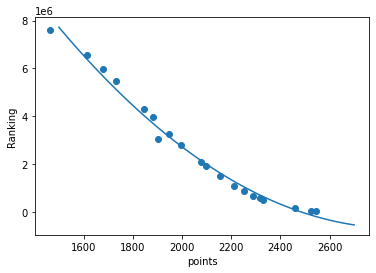

In [327]:
#this is just from searching through friends and top rankings on fpl website
#discrepency along the line is because when people draw they are all given same ranking
overallpnts =[1949, 1614, 1902, 2098, 2213, 2077, 2545, 2330, 2154, 2290 , 2319, 2253, 2523, 1881, 1679, 2461,1463,
              1733, 1847,1996]
ranking = [3282321, 6573368, 3058531, 1941652, 1116673, 2112453, 54140, 534847, 1508675, 704813, 580744,
           886715, 77022, 3965302, 5998772, 170565, 7621055, 5485941,4319545,2827589]
from sklearn.linear_model import LinearRegression
import numpy

mymodel = numpy.poly1d(numpy.polyfit(overallpnts, ranking, 2)) #fit a polynomial
myline = numpy.linspace(1500, 2700, 100)

plt.scatter(overallpnts, ranking)
plt.plot(myline, mymodel(myline))
plt.xlabel('points')
plt.ylabel('Ranking')
pred = mymodel(1990)
print("Your ranking is: ", pred)
print("You are in the top: ", pred/9000000*100,"%") #there were over 9 million players in gw 1. 

# Model B: Optimised

### Bench Boost Week 4

In [90]:
gw_preds = pd.read_csv('separated_predictions.csv')

In [15]:
bench_b_opt = ['vicente_guaita','neal_maupay','stuart_dallas','luke_ayling']
bench_gw = pick_bench_week(3,bench_b_opt, gw_preds)
bench_gw

4

In [16]:
gw_preds[(gw_preds.full_name.isin(bench_b_opt)) & (gw_preds.GW == 4)].total_points.sum()

11

In [17]:
model_b_opt_cap = pick_captain(model_b_optimal, fixture_difficulty, hist_df)

In [18]:
model_b_opt_cap #cant do this because using wc before this week, try again later

('mohamed_salah', 8, 13)

### Wild Card WK6

In [19]:
#if you want to check TransferAlgorithm.ipynb, we got the 58 from there as this was the money banked in gw5
hist_df[(hist_df.full_name.isin(teams3[4])) & (hist_df.GW == 5) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(bench_b_opt)) & (hist_df.GW == 5) & (hist_df.season_num == 5)].value.sum() + 16

956

In [20]:
wc1_b_opt = freehit_team(6, 'optimal', 956, gw_preds)

In [21]:
wc1_b_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
10,konstantinos_tsimikas,Liverpool,DEF,40,2.981641,0
12,harry_maguire,Manchester United,DEF,54,3.439909,7
9,ivan_toney,Brentford,FWD,63,3.489261,5
13,aaron_wan_bissaka,Manchester United,DEF,54,3.512742,2
14,thiago_emiliano_da_silva,Chelsea,DEF,54,3.525610,2
3,conor_gallagher,Crystal Palace,MID,57,3.838404,4
2,illan_meslier,Leeds,GK,50,3.866619,1
11,marcos_alonso,Chelsea,DEF,58,3.875672,1
1,hugo_lloris,Tottenham Hotspur,GK,56,4.045949,2
4,ismaila_sarr,Watford,MID,62,4.126737,9


In [22]:
new_bench_b_list = ['konstantinos_tsimikas','ivan_toney','conor_gallagher','illan_meslier']
new_bench_b_opt = {'DEF':'konstantinos_tsimikas', 'GK':'illan_meslier','MID':'conor_gallagher','FWD':'ivan_toney'}

In [25]:
wc1_trans_opt_b, teams5 = wildcard(new_bench_b_opt, new_bench_b_list, gw_preds, hist_df, wc1_b_opt,6,16)

nicolas_pépé 88
andros_townsend 33
jack_grealish 113
abdoulaye_doucouré 56
ilkay_gündogan 128
mohamed_salah 0
patrick_bamford 78
hee_chan_hwang 21
aaron_wan_bissaka 74
reece_james 16
harry_maguire 70
joão_pedro_cavaco_cancelo 5
hugo_lloris 59
aaron_ramsdale 11
ismaila_sarr 71
maxwel_cornet 10
jamie_vardy 115
emmanuel_dennis 60
marcos_alonso 116
trent_alexander_arnold 35
hee_chan_hwang 91
armando_broja 40
andros_townsend 93
emile_smith_rowe 33
thiago_emiliano_da_silva 88
gabriel_magalhães 35
armando_broja 86
odsonne_edouard 23
maxwel_cornet 82
jarrod_bowen 16
abdoulaye_doucouré 70
philippe_coutinho_correia 0
reece_james 60
hassane_kamara 15
odsonne_edouard 78
armando_broja 26
armando_broja 78
odsonne_edouard 13
hassane_kamara 58
kieran_trippier 8
odsonne_edouard 73
armando_broja 18
armando_broja 73
odsonne_edouard 9
odsonne_edouard 73
armando_broja 18
armando_broja 73
ivan_toney 7
ivan_toney 73
armando_broja 18
armando_broja 73
teemu_pukki 14
teemu_pukki 73
ivan_toney 4
ivan_toney 73
te

In [26]:
wc1_trans_opt_b

,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,6,None,None,0,0,42,jamie_vardy,11,53
1,7,andros_townsend,nicolas_pépé,1,10,28,marcos_alonso,0,28
2,8,abdoulaye_doucouré,jack_grealish,0,2,16,andros_townsend,2,18
3,9,mohamed_salah,ilkay_gündogan,10,24,38,mohamed_salah,24,62
4,10,hee_chan_hwang,patrick_bamford,0,2,33,mohamed_salah,5,38
5,11,reece_james,aaron_wan_bissaka,1,7,31,mohamed_salah,5,36
6,12,joão_pedro_cavaco_cancelo,harry_maguire,-3,12,59,mohamed_salah,8,67
7,13,aaron_ramsdale,hugo_lloris,0,7,51,mohamed_salah,6,57
8,14,maxwel_cornet,ismaila_sarr,0,3,33,mohamed_salah,15,48
9,15,emmanuel_dennis,jamie_vardy,1,2,28,mohamed_salah,6,34


### Triple Captain WK8

In [27]:
model_b_opt_cap = pick_captain(wc1_trans_opt_b, fixture_difficulty, hist_df)

In [28]:
model_b_opt_cap# still week 8 so we can use

('mohamed_salah', 17, 8)

### Free Hit WK18

In [31]:
#17 was a blank, so check week before
hist_df[(hist_df.full_name.isin(teams5[16])) & (hist_df.GW == 16) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(new_bench_b_list)) & (hist_df.GW == 16) & (hist_df.season_num == 5)].value.sum() + 40

985

In [32]:
fh1_b_opt = freehit_team(18, 'optimal', 985, gw_preds)

In [34]:
fh1_b_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
7,joelinton_cássio_apolinário_de_lira,Newcastle United,FWD,58,2.778079,2
4,gabriel_teodoro_martinelli_silva,Arsenal,MID,52,3.101198,15
5,martin_ødegaard,Arsenal,MID,55,3.192451,7
12,max_kilman,Wolverhampton Wanderers,DEF,45,3.235696,6
11,romain_saïss,Wolverhampton Wanderers,DEF,50,3.298658,7
6,allan_saint_maximin,Newcastle United,FWD,67,3.336133,1
1,bukayo_saka,Arsenal,MID,62,3.588256,7
0,hugo_lloris,Tottenham Hotspur,GK,54,3.822697,2
13,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,51,4.214909,6
2,mason_mount,Chelsea,MID,77,4.322896,3


In [35]:
fh1_b_opt['Actual Points'].sum()-15-6-2+7 #15 points on the bench, ouch, times like this bench strat could be improved

68

### Freehit WK30

In [44]:
hist_df[(hist_df.full_name.isin(teams5[28])) & (hist_df.GW == 29) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()\
+hist_df[(hist_df.full_name.isin(new_bench_b_list)) & (hist_df.GW == 29) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum() + 73


1053.0

In [45]:
fh2_b_opt = freehit_team(30, 'optimal', 1053, gw_preds)

In [46]:
fh2_b_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
12,conor_coady,Wolverhampton Wanderers,DEF,49,2.978595,1
14,aaron_cresswell,West Ham United,DEF,54,3.014094,1
10,romain_saïss,Wolverhampton Wanderers,DEF,51,3.129771,1
13,sergio_reguilón,Tottenham Hotspur,DEF,52,3.218667,2
9,matthew_cash,Aston Villa,DEF,52,3.515919,2
0,bukayo_saka,Arsenal,MID,67,3.593080,11
6,ollie_watkins,Aston Villa,FWD,75,3.725578,2
1,raphael_dias_belloli,Leeds,MID,65,3.730797,0
7,ivan_toney,Brentford,FWD,66,3.842436,2
4,kasper_schmeichel,Leicester City,GK,48,3.939379,3


In [47]:
fh2_b_opt['Actual Points'].sum()-1-11-3+15 #again a lot of points going on the bench

61

### Wild Card WK36

In [77]:
hist_df[(hist_df.full_name.isin(teams5[34])) & (hist_df.GW == 34) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(bench_b_opt)) & (hist_df.GW == 34) & (hist_df.season_num == 5)].value.sum() + 2

960

In [93]:
wc2_b_opt = freehit_team(36, 'optimal', 960, gw_preds) 

In [105]:
wc2_b_opt.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
19091,jack_harrison,Leeds,MID,55,2.258440,2
3254,matt_targett,Newcastle United,DEF,47,2.645560,-1
7889,trent_alexander_arnold,Liverpool,DEF,84,3.054588,2
9904,aaron_cresswell,West Ham United,DEF,55,3.236359,6
794,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,52,3.255245,2
23716,teemu_pukki,Norwich,FWD,61,3.278371,2
23715,teemu_pukki,Norwich,FWD,61,3.388046,2
19092,jack_harrison,Leeds,MID,55,3.407144,1
22121,richarlison_de_andrade,Everton,FWD,75,3.592977,2
795,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,52,3.601099,0


In [ ]:
new_bench_b_opt = {'GK': 'josé_malheiro_de_sá', 'DEF':'matt_targett','MID':'bruno_guimarães_rodriguez_moura', 'FWD':'teemu_pukki'}
new_bench_b_list = ['josé_malheiro_de_sá','matt_targett','bruno_guimarães_rodriguez_moura','teemu_pukki']

In [113]:
wc2_trans_opt_b, teams5 = wildcard(new_bench_b_opt, new_bench_b_list, gw_preds, hist_df, wc2_b_opt,36,2)

bruno_miguel_borges_fernandes 62
saïd_benrahma 3
tim_krul 63
alisson_ramses_becker 2


### Combine everything

In [115]:
model_b_opt_bc = pd.concat([model_b_optimal[:5], wc1_trans_opt_b[:30],wc2_trans_opt_b ])
model_b_opt_bc

,Unnamed: 0,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,0.0,1,None,None,0,None,51,bruno_miguel_borges_fernandes,20,71
1,1.0,2,david_raya_martin,rui_pedro_dos_santos_patrício,0,6,56,bruno_miguel_borges_fernandes,1,57
2,2.0,3,michail_antonio,ollie_watkins,1,11,54,michail_antonio,11,65
3,3.0,4,marc_cucurella,kieran_tierney,7,7,45,michail_antonio,-1,44
4,4.0,5,saïd_benrahma,jack_grealish,3,10,39,marc_cucurella,2,41
0,NaN,6,None,None,0,0,42,jamie_vardy,11,53
1,NaN,7,andros_townsend,nicolas_pépé,1,10,28,marcos_alonso,0,28
2,NaN,8,abdoulaye_doucouré,jack_grealish,0,2,16,andros_townsend,2,18
3,NaN,9,mohamed_salah,ilkay_gündogan,10,24,38,mohamed_salah,24,62
4,NaN,10,hee_chan_hwang,patrick_bamford,0,2,33,mohamed_salah,5,38


In [117]:
overall_wildcard_only_b = model_b_opt_bc.total_points.sum()
triple_cap = 13 #see earlier
benchboost = 11 #see earlier
freehitgw18 = 68-51 #it is only the difference that we add
freehitgw30 = 61-17

final_total_mod_b_opt = overall_wildcard_only_b + triple_cap+benchboost+freehitgw18+freehitgw30

In [118]:
final_total_mod_b_opt

2005

Your ranking is:  2699263.921250835
You are in the top:  29.9918213472315 %


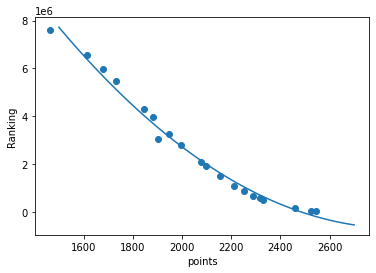

In [119]:
#this is just from searching through friends and top rankings on fpl website
#discrepency along the line is because when people draw they are all given same ranking
overallpnts =[1949, 1614, 1902, 2098, 2213, 2077, 2545, 2330, 2154, 2290 , 2319, 2253, 2523, 1881, 1679, 2461,1463,
              1733, 1847,1996]
ranking = [3282321, 6573368, 3058531, 1941652, 1116673, 2112453, 54140, 534847, 1508675, 704813, 580744,
           886715, 77022, 3965302, 5998772, 170565, 7621055, 5485941,4319545,2827589]
from sklearn.linear_model import LinearRegression
import numpy

mymodel = numpy.poly1d(numpy.polyfit(overallpnts, ranking, 2)) #fit a polynomial
myline = numpy.linspace(1500, 2700, 100)

plt.scatter(overallpnts, ranking)
plt.plot(myline, mymodel(myline))
plt.xlabel('points')
plt.ylabel('Ranking')
pred = mymodel(2005)
print("Your ranking is: ", pred)
print("You are in the top: ", pred/9000000*100,"%") #there were over 9 million players in gw 1. 

## Model B: Cheapest

### Triple Captain: WK13

In [120]:
model_b_cheap_cap = pick_captain(model_b_cheapest, fixture_difficulty, hist_df)

In [121]:
model_b_cheap_cap #week 13 - we can use this as this model doesnt have a wc/freehit until wk16

('mohamed_salah', 8, 13)

In [122]:
bench_b_ch = ['ellery_balcombe', 'neco_williams','josh_brownhill', 'stipe_perica']
bench_dict_ch_b = {'GK': 'ellery_balcombe', 'DEF': 'neco_williams','MID':'josh_brownhill', 'FWD': 'stipe_perica'}

In [127]:
bench_gw_b_ch = pick_bench_week(1.1,bench_b_ch, gw_preds) #now see if bench any better
bench_gw_b_ch #this is after the wc and freehit, so retry after

26

### Free hit WK18

In [128]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 18)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])
cheapest #interesting that it is the same as model a's cheapest, but different preds

,full_name,player_team_name,position,value,predicted,actual
2437,scott_carson,Manchester City,GK,39,0.045009,0
4604,konstantinos_tsimikas,Liverpool,DEF,38,0.385872,0
17478,jamie_shackleton,Leeds,MID,44,1.148616,0
22595,dane_scarlett,Tottenham Hotspur,FWD,45,0.120323,0


In [131]:
hist_df[(hist_df.full_name.isin(teams4[16])) & (hist_df.GW == 16) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()\
+hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 16) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()+29

968.0

In [132]:
968 - cheapest.value.sum()

802

In [133]:
fh1_b_ch = freehit_team(18, 'cheapest', 802, gw_preds, cheapest)
fh1_b_ch.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
4,joelinton_cássio_apolinário_de_lira,Newcastle United,FWD,58,2.778079,2
3,martin_ødegaard,Arsenal,MID,55,3.192451,7
8,max_kilman,Wolverhampton Wanderers,DEF,45,3.235696,6
9,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,51,4.214909,6
0,mason_mount,Chelsea,MID,77,4.322896,3
6,reece_james,Chelsea,DEF,63,4.410823,6
1,jack_grealish,Manchester City,MID,76,4.442817,0
7,andrew_robertson,Liverpool,DEF,71,4.519317,9
5,harry_kane,Tottenham Hotspur,FWD,121,5.196770,6
2,heung_min_son,Tottenham Hotspur,MID,103,5.326836,7


In [134]:
fh1_b_ch['Actual Points'].sum() +7 #the bench received 0 points, so we don't do anything

59

### Wild Card WK19

In [136]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 19)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 19)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 19)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 19)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])
cheapest 

,full_name,player_team_name,position,value,predicted,actual
1460,patrik_gunnarsson,Brentford,GK,39,0.050864,0
9467,daniel_amartey,Leicester City,DEF,38,0.354450,-1
11623,james_mcarthur,Crystal Palace,MID,43,0.198864,0
25051,jürgen_locadia,Brighton and Hove Albion,FWD,45,0.207683,0


In [140]:
hist_df[(hist_df.full_name.isin(teams4[17])) & (hist_df.GW == 16) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 16) & (hist_df.season_num == 5)].value.sum() + 29

953

In [141]:
953-cheapest.value.sum()

788

In [142]:
wc1_b_ch = freehit_team(19, 'cheapest', 788, gw_preds, cheapest) #note, as theyre double gws this wont match with the transfer printout
wc1_b_ch.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
10,davinson_sánchez,Tottenham Hotspur,DEF,45,3.134917,5
4,callum_wilson,Newcastle United,FWD,74,3.469332,1
5,ollie_watkins,Aston Villa,FWD,79,3.861380,2
9,antonio_rüdiger,Chelsea,DEF,62,3.902395,2
6,robert_sánchez,Brighton and Hove Albion,GK,46,3.981754,9
8,joão_pedro_cavaco_cancelo,Manchester City,DEF,68,4.133759,4
7,reece_james,Chelsea,DEF,63,4.254533,0
2,gabriel_teodoro_martinelli_silva,Arsenal,MID,54,4.312922,3
1,riyad_mahrez,Manchester City,MID,86,4.611662,10
3,heung_min_son,Tottenham Hotspur,MID,104,5.349231,8


In [143]:
new_bench_b_ch = {'GK':'patrik_gunnarsson','DEF':'daniel_amartey','MID':'james_mcarthur','FWD':'jürgen_locadia'}

In [214]:
wc1_trans_ch, teams7 = wildcard(new_bench_b_ch, list(cheapest.full_name), gw_preds, hist_df, wc1_b_ch,19,29)

raheem_sterling 135
mohamed_salah 5
riyad_mahrez 91
jarrod_bowen 25
ollie_watkins 101
emmanuel_dennis 40
robert_sánchez 85
aaron_ramsdale 34
callum_wilson 106
odsonne_edouard 41
heung_min_son 144
philippe_coutinho_correia 72
davinson_sánchez 117
kieran_trippier 67
gabriel_teodoro_martinelli_silva 120
dejan_kulusevski 60
odsonne_edouard 125
armando_broja 70
reece_james 128
trent_alexander_arnold 43
armando_broja 98
ivan_toney 32
ivan_toney 98
armando_broja 43
armando_broja 98
teemu_pukki 39
teemu_pukki 98
ivan_toney 29
ivan_toney 98
teemu_pukki 38
kieran_trippier 87
virgil_van_dijk 19
aaron_ramsdale 70
david_raya_martin 27
david_raya_martin 70
martin_dubravka 26
martin_dubravka 70
aaron_ramsdale 19


In [215]:
wc1_trans_ch

,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,19,None,None,0,0,58,raheem_sterling,14,72
1,20,mohamed_salah,raheem_sterling,0,0,19,joão_pedro_cavaco_cancelo,6,25
2,21,jarrod_bowen,riyad_mahrez,9,21,56,mohamed_salah,7,63
3,22,emmanuel_dennis,ollie_watkins,2,2,27,mohamed_salah,0,27
4,23,aaron_ramsdale,robert_sánchez,4,8,22,mohamed_salah,0,22
5,24,odsonne_edouard,callum_wilson,0,1,38,mohamed_salah,1,39
6,25,philippe_coutinho_correia,heung_min_son,2,2,22,philippe_coutinho_correia,2,24
7,26,kieran_trippier,davinson_sánchez,1,0,56,kieran_trippier,0,56
8,27,dejan_kulusevski,gabriel_teodoro_martinelli_silva,0,8,25,philippe_coutinho_correia,3,28
9,28,armando_broja,odsonne_edouard,0,4,73,dejan_kulusevski,10,83


In [187]:
bench_gw_b_ch = pick_bench_week(3.2,list(cheapest.full_name), gw_preds) #now see if bench any better
bench_gw_b_ch #higher values were selecting gw 36 and gw4 which we couldnt use

38

In [186]:
#just going to pick next threshold above 1 after gw19 which is gw20
gw_preds[gw_preds.full_name.isin(cheapest.full_name)].groupby('GW').sum()['predicted']

GW
1     2.699291
2     4.175642
3     4.202937
4     4.979826
5     3.095065
6     2.841447
7     3.038327
8     2.843713
9     4.004030
10    4.402693
11    3.761613
12    3.292170
13    3.288933
14    2.547775
15    1.640933
16    1.030407
17    0.647570
19    0.811861
20    2.264741
21    0.423874
22    3.018730
23    1.484697
24    2.380295
25    2.638545
26    4.558512
27    4.260599
28    4.896734
29    3.914477
30    2.656496
31    3.426996
32    2.801333
33    4.360201
34    3.817718
35    3.043636
36    6.738462
37    7.083847
38    2.574378
Name: predicted, dtype: float64

In [189]:
gw_preds[(gw_preds.full_name.isin(cheapest.full_name))&(gw_preds.GW == 20)].actual #8 points

1461     0
9468     8
11624    0
25052    0
Name: actual, dtype: int64

### Freehit WK30

In [190]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])

In [191]:
cheapest

,full_name,player_team_name,position,value,predicted,actual
750,jed_steer,Aston Villa,GK,39,0.105503,0
9477,daniel_amartey,Leicester City,DEF,39,2.607965,2
12772,nampalys_mendy,Leicester City,MID,43,1.079461,2
22609,dane_scarlett,Tottenham Hotspur,FWD,45,0.228059,0


In [193]:
hist_df[(hist_df.full_name.isin(teams4[28])) & (hist_df.GW == 28) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()\
+hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 28) & (hist_df.season_num == 5)].groupby('full_name').mean().value.sum()+13

941.0

In [194]:
941-cheapest.value.sum()

775

In [195]:
fh2_b_ch = freehit_team(30, 'cheapest', 775, gw_preds, cheapest) #note, as theyre double gws this wont match with the transfer printout
fh2_b_ch.sort_values('Predicted Points')

,Name,Team,Position,Value,Predicted Points,Actual Points
9,conor_coady,Wolverhampton Wanderers,DEF,49,2.978595,1
10,aaron_cresswell,West Ham United,DEF,54,3.014094,1
7,romain_saïss,Wolverhampton Wanderers,DEF,51,3.129771,1
6,matthew_cash,Aston Villa,DEF,52,3.515919,2
0,raphael_dias_belloli,Leeds,MID,65,3.730797,0
4,ivan_toney,Brentford,FWD,66,3.842436,2
8,josé_malheiro_de_sá,Wolverhampton Wanderers,GK,53,4.015853,1
2,harvey_barnes,Leicester City,MID,65,4.163084,5
3,philippe_coutinho_correia,Aston Villa,MID,75,4.242095,2
5,harry_kane,Tottenham Hotspur,FWD,124,4.968919,13


In [197]:
fh2_b_ch['Actual Points'].sum()+2+15

60

### Wildcard WK36

In [198]:
gk_cheap = gw_preds[(gw_preds.position == 'GK') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position', 'value','predicted','actual']]
def_cheap = gw_preds[(gw_preds.position == 'DEF') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name','position', 'value','predicted','actual']]
mid_cheap = gw_preds[(gw_preds.position == 'MID') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value','predicted', 'actual']]
fwd_cheap = gw_preds[(gw_preds.position == 'FWD') & (gw_preds.GW == 30)].sort_values(['value','predicted'], ascending = [True, False])[['full_name', 'player_team_name', 'position','value', 'predicted', 'actual']]

cheapest = pd.concat([gk_cheap.head(1), def_cheap.head(1), mid_cheap.head(1), fwd_cheap.head(1)])
cheapest 

,full_name,player_team_name,position,value,predicted,actual
750,jed_steer,Aston Villa,GK,39,0.105503,0
9477,daniel_amartey,Leicester City,DEF,39,2.607965,2
12772,nampalys_mendy,Leicester City,MID,43,1.079461,2
22609,dane_scarlett,Tottenham Hotspur,FWD,45,0.228059,0


In [203]:
hist_df[(hist_df.full_name.isin(teams7[34])) & (hist_df.GW == 34) & (hist_df.season_num == 5)].value.sum()+ \
hist_df[(hist_df.full_name.isin(cheapest.full_name)) & (hist_df.GW == 34) & (hist_df.season_num == 5)].value.sum() + 4

944

In [204]:
944-cheapest.value.sum()

778

In [ ]:
new_bench_b_ch = {'GK': 'jed_steer','DEF':'daniel_amartey','MID': 'nampalys_mendy','FWD':'dane_scarlett'}

In [210]:
wc2_trans_ch, teams8 = wildcard(new_bench_b_ch, list(cheapest.full_name), gw_preds, hist_df, wc1_b_ch,36,4)

raheem_sterling 109
jarrod_bowen 41
robert_sánchez 86
alisson_ramses_becker 25


In [211]:
wc1_trans_ch

,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,36,None,None,0,0,114,heung_min_son,20,134
1,37,jarrod_bowen,raheem_sterling,0,14,57,jarrod_bowen,14,71
2,38,alisson_ramses_becker,robert_sánchez,2,3,71,jarrod_bowen,2,73


### Combine everything

In [218]:
model_b_ch_bc = pd.concat([model_b_cheapest[:18], wc1_trans_ch[:30],wc2_trans_ch ])
model_b_ch_bc

,Unnamed: 0,GW,transferred_in,transferred_out,out_points,in_points,points,captain,captain_points,total_points
0,0.0,1,None,None,0,None,51,bruno_miguel_borges_fernandes,20,71
1,1.0,2,david_raya_martin,rui_pedro_dos_santos_patrício,0,6,56,bruno_miguel_borges_fernandes,1,57
2,2.0,3,michail_antonio,ollie_watkins,1,11,54,michail_antonio,11,65
3,3.0,4,marc_cucurella,kieran_tierney,7,7,45,michail_antonio,-1,44
4,4.0,5,saïd_benrahma,jack_grealish,3,10,39,marc_cucurella,2,41
5,5.0,6,abdoulaye_doucouré,heung_min_son,7,11,48,saïd_benrahma,3,51
6,6.0,7,pontus_jansson,luke_shaw,2,5,48,michail_antonio,2,50
7,7.0,8,mohamed_salah,bruno_miguel_borges_fernandes,5,13,40,mohamed_salah,13,53
8,8.0,9,mateo_kovacic,diogo_jota,11,11,56,mohamed_salah,24,80
9,9.0,10,reece_james,nélson_cabral_semedo,2,21,45,mohamed_salah,5,50


In [224]:
overall_wildcard_only_ch_b = model_b_ch_bc.total_points.sum()
triple_cap = 13 #see earlier
benchboost = 8 #see earlier
freehitgw18 = 59-45 #it is only the difference that we add
freehitgw30 = 60-8

final_total_mod_b_ch = overall_wildcard_only_ch_b + triple_cap+benchboost+freehitgw18+freehitgw30

In [225]:
final_total_mod_b_ch

2231

Your ranking is:  1183369.4941556528
You are in the top:  13.148549935062809 %


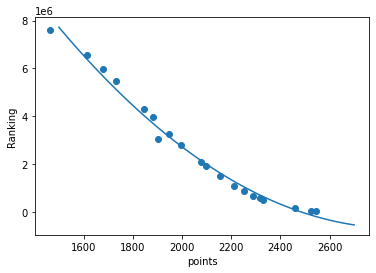

In [226]:
#this is just from searching through friends and top rankings on fpl website
#discrepency along the line is because when people draw they are all given same ranking
overallpnts =[1949, 1614, 1902, 2098, 2213, 2077, 2545, 2330, 2154, 2290 , 2319, 2253, 2523, 1881, 1679, 2461,1463,
              1733, 1847,1996]
ranking = [3282321, 6573368, 3058531, 1941652, 1116673, 2112453, 54140, 534847, 1508675, 704813, 580744,
           886715, 77022, 3965302, 5998772, 170565, 7621055, 5485941,4319545,2827589]
from sklearn.linear_model import LinearRegression
import numpy

mymodel = numpy.poly1d(numpy.polyfit(overallpnts, ranking, 2)) #fit a polynomial
myline = numpy.linspace(1500, 2700, 100)

plt.scatter(overallpnts, ranking)
plt.plot(myline, mymodel(myline))
plt.xlabel('points')
plt.ylabel('Ranking')
pred = mymodel(2231)
print("Your ranking is: ", pred)
print("You are in the top: ", pred/9000000*100,"%") #there were over 9 million players in gw 1. 